# FairWorkflows execution demo

## Define the steps of your workflow
Each step should be its own function. Mark the function as such with the @fairstep decorator.

In [1]:
from fairworkflows import is_fairworkflow, is_fairstep, FairStep, FairWorkflow

In [17]:
@is_fairstep(label='Addition')
def add(a:float, b:float) -> float:
    """Adding up numbers!"""
    return a + b

In [18]:
@is_fairstep(label='Subtraction')
def sub(a: float, b: float) -> float:
    """Subtracting numbers."""
    return a - b

In [19]:
@is_fairstep(label='Multiplication')
def mul(a: float, b: float) -> float:
    """Multiplying numbers."""
    return a * b

In [20]:
@is_fairstep(label='A strange step with little use')
def weird(a: float, b:float) -> float:
    """A weird function"""
    return a * 2 + b * 4
    

## Define your workflow using @fairworkflow
Now write a function which describes your workflow. Mark this function with the @fairworkflow decorator.

In [21]:
@is_fairworkflow(label='My Workflow')
def my_workflow(in1, in2, in3):
    """
    A simple addition, subtraction, multiplication workflow
    """
    t1 = add(in1, in2)
    t2 = sub(in1, in2)
    t3 = mul(weird(t1, in3), t2)
    return t3

## Create an instance of your workflow and display it

In [22]:
fw = FairWorkflow.from_function(my_workflow)
type(fw)

fairworkflows.fairworkflow.FairWorkflow

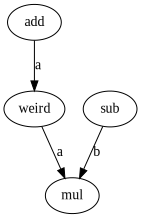

In [23]:
fw.display()

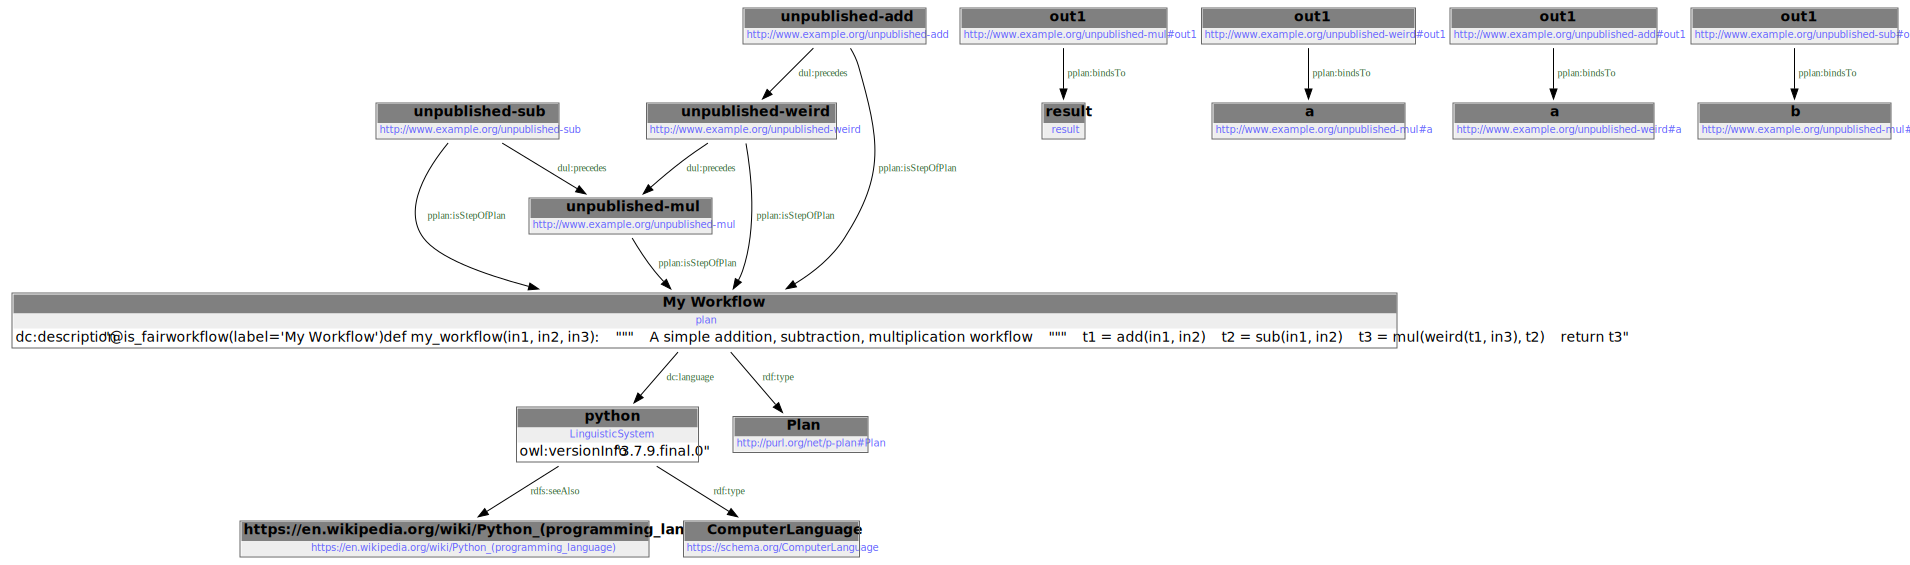

In [24]:
fw.display_rdf()

## Publish the (prospective) workflow
You may publish the workflow, and its steps, as nanopublications in the usual manner:

In [25]:
#fw.publish_as_nanopub()

Be warned though - the above will keep publishing to the 'real' nanopub server network. For testing you may prefer to publish to the test servers as follows (note that this will refuse to publish a workflow you have already published :

In [27]:
fw.publish_as_nanopub(use_test_server=True, publish_steps=True)

Published to http://purl.org/np/RArfw5pDGpdbmSFmqy43E8Q0qTESjloVrHPkGgWrrMk68
Published concept to http://purl.org/np/RArfw5pDGpdbmSFmqy43E8Q0qTESjloVrHPkGgWrrMk68#step
Published to http://purl.org/np/RABC9qOhvWb89wzSDhNfhMmA15cMHp7zfFaHBiwMZC7iA
Published concept to http://purl.org/np/RABC9qOhvWb89wzSDhNfhMmA15cMHp7zfFaHBiwMZC7iA#step
Published to http://purl.org/np/RAkelHhx0VSs6t1vvr15xXks3G7Hxast2jY80Eo9433ew
Published concept to http://purl.org/np/RAkelHhx0VSs6t1vvr15xXks3G7Hxast2jY80Eo9433ew#step
Published to http://purl.org/np/RAeVkW7gfsfXlmZlv9QkgI_C7DmNOCP6B4pEyJKwEIBgo
Published concept to http://purl.org/np/RAeVkW7gfsfXlmZlv9QkgI_C7DmNOCP6B4pEyJKwEIBgo#step
Published to http://purl.org/np/RAk8NF9sc1SpTS6CBvlvVV1QKRPBj040ezmar4nXclqGs
Published concept to http://purl.org/np/RAk8NF9sc1SpTS6CBvlvVV1QKRPBj040ezmar4nXclqGs#plan


{'nanopub_uri': 'http://purl.org/np/RAk8NF9sc1SpTS6CBvlvVV1QKRPBj040ezmar4nXclqGs',
 'concept_uri': 'http://purl.org/np/RAk8NF9sc1SpTS6CBvlvVV1QKRPBj040ezmar4nXclqGs#plan'}

You can then find your nanopublications by replacing the base of the URI with http://test-server.nanopubs.lod.labs.vu.nl/

## Execute your workflow using .execute()
Set num_threads greater than 1 if you wish to exploit parallelisation in your workflow. The retrospective provenance is also returned as a (nano) Publication object, that can optionally be published.

In [28]:
result, prov = fw.execute(1, 4, 3)
result

-66

 ## Retrospective prov
 The retrospective prov object is not yet implemented, pending one of the RDF tasks set out in the planning document. For now, you may see simply the provenance trace for this run. We wish to turn this into a (Plex) RDF nanopublication:

In [31]:
type(prov)

nanopub.publication.Publication

In [32]:
print(prov)

Original source URI = None
@prefix : <http://purl.org/nanopub/temp/mynanopub#> .
@prefix np: <http://www.nanopub.org/nschema#> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:Head {
    : a np:Nanopublication ;
        np:hasAssertion :assertion ;
        np:hasProvenance :provenance ;
        np:hasPublicationInfo :pubInfo .
}

:assertion {
    :retroprov a prov:Activity ;
        rdfs:label """2021-02-16 13:39:47,454 - Running step: add
2021-02-16 13:39:47,455 - Running step: sub
2021-02-16 13:39:47,455 - Running step: weird
2021-02-16 13:39:47,455 - Running step: mul
""" ;
        prov:wasDerivedFrom <http://purl.org/np/RAk8NF9sc1SpTS6CBvlvVV1QKRPBj040ezmar4nXclqGs#plan> .
}

:provenance {
    :assertion prov:generatedAtTime "2021-02-16T13:39:47.456746"^^xsd:dateTime .
}

:pubInfo {
    : prov:generatedAtTime "2021-02-16T13:39:47.456746"^^xsd:dateTime ;
        prov:wasAttribu

### Provide semantic annotations for input and output variables
If you wish to specify semantic types for the inputs/outputs to a step, you can do so in the arguments to the decorator.
For example, if you have an input parameter 'a', you can write a='http://www.example.org/distance' to assign that (semantic) type to a. As output of functions is not named in python, you can specify the same but with 'out1', 'out2' etc. See the following example:

In [33]:
@is_fairstep(label='Addition', a='http://www.example.org/distance', returns='http://www.example.org/mass')
def add(a:float, b:float) -> float:
    return a + b

If we now look at the RDF generated for the step, we will see that input parameter 'a' and the step output ('out1') both have the (additional) semantic types specified.

In [34]:
# ACTIONS:
# Add language and version to nanopubs (i.e. what the description is written in)
print(add._fairstep)

Step URI = http://www.example.org/unpublished-add
@prefix bpmn: <http://dkm.fbk.eu/index.php/BPMN2_Ontology#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix pplan: <http://purl.org/net/p-plan#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .

_:Nd2641b6028ec4f02b285cf7d74ef3902 {
    [] a bpmn:ScriptTask,
            pplan:Step ;
        rdfs:label "Addition" ;
        dc:description """@is_fairstep(label='Addition', a='http://www.example.org/distance', returns='http://www.example.org/mass')
def add(a:float, b:float) -> float:
    return a + b
""" ;
        dc:language [ a schema:ComputerLanguage ;
                rdfs:label "python" ;
                rdfs:seeAlso <https://en.wikipedia.org/wiki/Python_(programming_language)> ;
                owl:versionInfo "3.7.9.final.0" ] ;
        pplan:hasInputVar [ a pplan:Variable,
                    <http://www.example.org/distance> ;
      

### Specify more than one semantic type for a parameter
You can provide a list of URIs if you want to specify several semantic types for e.g. parameter 'a':

In [35]:
@is_fairstep(label='Addition', a=['http://www.example.org/distance', 'http://www.example.org/number'])
def another_step(a:float, b:float) -> float:
    """Add two numbers together"""
    return a + b

In [36]:
print(another_step._fairstep)

Step URI = http://www.example.org/unpublished-another_step
@prefix bpmn: <http://dkm.fbk.eu/index.php/BPMN2_Ontology#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix pplan: <http://purl.org/net/p-plan#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .

_:N0d48ef67a35e4611b0c5eaaa15436b88 {
    [] a bpmn:ScriptTask,
            pplan:Step ;
        rdfs:label "Addition" ;
        dc:description """@is_fairstep(label='Addition', a=['http://www.example.org/distance', 'http://www.example.org/number'])
def another_step(a:float, b:float) -> float:
    \"\"\"Add two numbers together\"\"\"
    return a + b
""" ;
        dc:language [ a schema:ComputerLanguage ;
                rdfs:label "python" ;
                rdfs:seeAlso <https://en.wikipedia.org/wiki/Python_(programming_language)> ;
                owl:versionInfo "3.7.9.final.0" ] ;
        pplan:hasInputVar [ a pplan:Variable,
       

You can check the programming language that was used for writing the step:

In [39]:
print(another_step._fairstep.language)

LinguisticSystem with type=https://schema.org/ComputerLanguage, label=python, seeAlso=https://en.wikipedia.org/wiki/Python_(programming_language), versionInfo=3.7.9.final.0


## Semantic types for function producing multiple outputs
Provide 'out' with a tuple of the same length as the number of function outputs. You can use None for any you do not wish to assign a particular semantic type to.

In [40]:
from typing import Tuple
@is_fairstep(label='Addition and subtraction', returns=('http://www.example.org/distance', 'http://www.example.org/number'))
def another_step(a:float, b:float) -> Tuple[float, float]:
    return a + b, a - b

In [41]:
print(another_step._fairstep)

Step URI = http://www.example.org/unpublished-another_step
@prefix bpmn: <http://dkm.fbk.eu/index.php/BPMN2_Ontology#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix pplan: <http://purl.org/net/p-plan#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .

_:N049c5deb99fe48d1a04b060b07a455b3 {
    [] a bpmn:ScriptTask,
            pplan:Step ;
        rdfs:label "Addition and subtraction" ;
        dc:description """@is_fairstep(label='Addition and subtraction', returns=('http://www.example.org/distance', 'http://www.example.org/number'))
def another_step(a:float, b:float) -> Tuple[float, float]:
    return a + b, a - b
""" ;
        dc:language [ a schema:ComputerLanguage ;
                rdfs:label "python" ;
                rdfs:seeAlso <https://en.wikipedia.org/wiki/Python_(programming_language)> ;
                owl:versionInfo "3.7.9.final.0" ] ;
        pplan:hasInputVar [ a pplan

As before, you may provide a list of URIs for each output. If you do not want to provide semantic types for a particular output, simply pass None:

In [42]:
from typing import Tuple
@is_fairstep(label='Addition and subtraction', returns=(['http://www.example.org/distance', 'http://www.example.org/number'], None))
def another_step(a:float, b:float) -> Tuple[float, float]:
    """This step returns an addition and a subtraction of its inputs"""
    return a + b, a - b

In [43]:
print(another_step._fairstep)

Step URI = http://www.example.org/unpublished-another_step
@prefix bpmn: <http://dkm.fbk.eu/index.php/BPMN2_Ontology#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix pplan: <http://purl.org/net/p-plan#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .

_:N230e6f57b6fc4bc1be68bcfa1a6edb6c {
    [] a bpmn:ScriptTask,
            pplan:Step ;
        rdfs:label "Addition and subtraction" ;
        dc:description """@is_fairstep(label='Addition and subtraction', returns=(['http://www.example.org/distance', 'http://www.example.org/number'], None))
def another_step(a:float, b:float) -> Tuple[float, float]:
    \"\"\"This step returns an addition and a subtraction of its inputs\"\"\"
    return a + b, a - b
""" ;
        dc:language [ a schema:ComputerLanguage ;
                rdfs:label "python" ;
                rdfs:seeAlso <https://en.wikipedia.org/wiki/Python_(programming_language)> ;
 